# Notebook2: Predicting CO2 emissions using Neural Networks

Readme: In this notebook, NN models are constructed for CO2 Emission prediction, and the best model is selected and K-means validation is applied.

- **Notebook content**:
    - Design the architecture of NN and explore different model configuration

    - Tune hyperparameters and select the best model

- **Notebook Output**:

    - Best model file

    - The validation and test results of the best model

In [69]:
# %pip install "numpy<2" torch torchvision scikit-learn
# %pip install wandb

In [70]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1 Define Functions

In [71]:
# Define functions
import seaborn as sns
import torch

# 1 plot related functions----------------
# plot predict and true values on validation dataset
def plot_pred_true(y_test, y_pred, ax):

    data = pd.DataFrame({'y_obs': y_test, 'y_pred': y_pred})

    # plt.figure(figsize=(5, 5))
    sns.scatterplot(data=data, x='y_obs', y='y_pred', s=10, ax=ax)
    ax.plot(y_test, y_test, color='red', label='y=x')          # plot the line y=x
    ax.set_title('Observed vs Predicted values in Test Dataset')   # title
    ax.set_xlabel('Observed values')       # label for the x-axis
    ax.set_ylabel('Predicted values')      # label for the y-axis
    ax.legend()
    ax.grid(True)

# plot the loss value on training and validation dataset
def plot_train_val_loss(train_loss, val_loss, ax):
    
    # ax.figure(figsize=(5, 5))

    ax.plot(train_loss, label='train loss')
    ax.plot(val_loss, label='val loss')
    ax.set_title('Train vs Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# 2 Other functions---------------------
# get the prediction and true values
def model_prediction(model, val_loader, device):

    model.eval()
    pred = []
    target = []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)      # predicted value

            pred.extend(y_pred.cpu().numpy())
            target.extend(y.cpu().numpy())

    # Merge all the predictions and targets
    predictions = np.concatenate(pred, axis=0)
    labels = np.concatenate(target, axis=0)
    return predictions, labels

## 2 Data Preparation

In [72]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Load and Divide Traning and Testing Data

Load the test and train dataset

In [ ]:
# Import data
trainset_df = pd.read_csv('Dataset1_train.csv')
testset_df = pd.read_csv('Dataset1_test.csv')


In [74]:
trainset_df

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,...,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z,Make,CO2 Emissions(g/km)
0,4.0,6,1,5.000000,14.7,10.3,12.7,22,0,0,...,0,0,0,0,0,0,1,0,NISSAN,299
1,2.4,4,1,6.000000,9.8,6.7,8.4,34,0,0,...,0,0,0,0,0,0,1,0,HYUNDAI,193
2,2.0,4,1,8.000000,11.3,7.1,9.4,30,0,0,...,0,0,0,0,0,0,0,1,BMW,221
3,2.5,4,1,6.000000,10.1,7.7,9.0,31,0,0,...,1,0,0,0,0,0,1,0,TOYOTA,212
4,5.0,8,1,8.000000,15.8,10.3,13.3,21,0,0,...,0,0,0,0,0,0,0,1,JAGUAR,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,2.0,4,1,6.000000,9.3,7.3,8.4,34,0,0,...,0,0,0,0,0,0,0,1,MINI,197
5903,5.6,8,1,7.000000,17.5,12.8,15.4,18,0,1,...,0,1,0,0,0,0,1,0,NISSAN,362
5904,3.5,6,1,6.000000,8.1,8.5,8.3,34,0,0,...,0,1,0,0,0,0,1,0,TOYOTA,193
5905,2.5,4,1,6.854093,9.5,7.4,8.6,33,0,0,...,1,0,0,0,0,0,1,0,NISSAN,198


In [75]:
X_train = trainset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_train = trainset_df['CO2 Emissions(g/km)']

X_test = testset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_test = testset_df['CO2 Emissions(g/km)']

In [94]:
X_train

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,...,Vehicle Class_STATION WAGON - SMALL,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,4.0,6,1,5.000000,14.7,10.3,12.7,22,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2.4,4,1,6.000000,9.8,6.7,8.4,34,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2.0,4,1,8.000000,11.3,7.1,9.4,30,0,0,...,0,1,0,0,0,0,0,0,0,1
3,2.5,4,1,6.000000,10.1,7.7,9.0,31,0,0,...,0,0,1,0,0,0,0,0,1,0
4,5.0,8,1,8.000000,15.8,10.3,13.3,21,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,2.0,4,1,6.000000,9.3,7.3,8.4,34,0,0,...,0,1,0,0,0,0,0,0,0,1
5903,5.6,8,1,7.000000,17.5,12.8,15.4,18,0,1,...,0,0,0,1,0,0,0,0,1,0
5904,3.5,6,1,6.000000,8.1,8.5,8.3,34,0,0,...,0,0,0,1,0,0,0,0,1,0
5905,2.5,4,1,6.854093,9.5,7.4,8.6,33,0,0,...,0,0,1,0,0,0,0,0,1,0


### Setup pipline for Standardisation

In [77]:
binary_columns = X_train.columns[X_train.nunique() == 2].tolist()  
numerical_columns = [col for col in X_train.columns if col not in binary_columns]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # StandardScale
    ], 
    remainder='passthrough'  # keep dummy variable
)

# Setup pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [78]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

Inspect the processed data

In [79]:
feature_names = list(X_train) 
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Processed Train Dataset：")
print(X_train_df.head())

print("Processed Test Dataset：")
print(X_test_df.head())


Processed Train Dataset：
   Engine Size(L)  Cylinders  Gearbox_Type  Gearbox_Number  \
0        0.612690   0.200638     -1.602571        0.606404   
1       -0.567895  -0.889172     -0.750938       -0.792804   
2       -0.863042  -0.889172      0.952329       -0.364475   
3       -0.494109  -0.889172     -0.750938       -0.707138   
4        1.350555   1.290448      0.952329        0.920512   

   Fuel Consumption City (L/100 km)  Fuel Consumption Hwy (L/100 km)  \
0                          0.563352                         0.591736   
1                         -1.064801                        -0.897681   
2                         -0.883895                        -0.551305   
3                         -0.612536                        -0.689855   
4                          0.563352                         0.799561   

   Fuel Consumption Comb (L/100 km)  Fuel Consumption Comb (mpg)  \
0                         -0.753140                          1.0   
1                          0.9101

In [101]:
# Prepare the Dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to Tensor
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Load the training data and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_val_tensor,y_test_tensor)

# Set hyperparameters
batch_size = 64  # batch size

# Create data loader
train_Loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_Loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



## 3 Best Models

#### Pre: k-fold Import K-fold Cross-validation Method

In [95]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=20, shuffle=True, random_state=42) # Set randon seed to make sure the results are reproducible

Import metrics

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

### 3.1 Neural Network Model

#### 3.1.1 Use W&B Grid Search to Find Best NN Parameter Set

In [81]:
import wandb

wandb.login(key="47ea61c7ee69e2e0e1cc46ed5c31bd6168f9f9db")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

Neural Network Structure

In [82]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [83]:
from torch.utils.data import random_split

# Calculate the sizes for train and validation splits
num_total = len(train_dataset)
num_train = int(0.9 * num_total)
num_val = num_total - num_train

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders for each subset
train_Loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_Loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [84]:
# Hyperparameter grid
hidden_units_options = [32, 64, 128]    # Numbers of neurons in each hidden layer
hidden_layers_options = [2, 3, 4]       # Numbers of hidden layers
learning_rates = [0.1, 0.01, 0.001]     # Learning rates

max_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

learning_rate = 0.02        # Learning rate
n_epochs = 100 # Numebr of epochs

# Define the loss function and the optimizer
criterion = nn.MSELoss()    # Mean Squared Error for Linear Regression


In [85]:
# Define helper functions
# Train epoch function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # for features, target in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(features) # Forward pass
        loss = criterion(outputs, target)

        loss.backward()  # Backward pass
        optimizer.step() # Update the weights

        running_loss += loss.item() * features.size(0)

    return running_loss / len(train_loader.dataset)

# Validation epoch function
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for features, target in val_loader:
            # print(featuresfeatures.size(0))
            features, target = features.to(device), target.to(device)
            # features = features.view(features.size(0), -1)

            outputs = model(features)
            loss = criterion(outputs, target)
            val_loss += loss.item() * features.size(0)

    return val_loss / len(val_loader.dataset)



In [86]:
from itertools import product
import torch.optim as optim

for hidden_units, hidden_layers, lr in product(hidden_units_options, hidden_layers_options, learning_rates):

    # Configurations
    config = {
        "hidden_units": hidden_units,
        "hidden_layers": hidden_layers,
        "learning_rate": lr,
        "max_epochs": max_epochs,
        "patience": patience
    }

    # Start a new W&B run for each configuration
    wandb.init(project='DE_Groupwork_G4_stage1', config=config, reinit=True)

    model = MultiLayerPerceptron(input_size=input_size, 
                             hidden_size=config["hidden_units"], 
                             num_layers=config["hidden_layers"], 
                             output_size=1).to(device)


    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_test_loss = float('inf')
    epochs_without_improvement = 0
        
    for epoch in range(1, max_epochs + 1):
        train_loss = train_epoch(model, train_Loader, criterion, optimizer, device)
       
        test_loss = val_epoch(model, test_Loader, criterion, device)

        # Log metrics to W&B
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": test_loss})
        
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {test_loss:.4f}")
        
        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    wandb.finish()

print("Training complete for all configurations.")


Epoch 001 | Train Loss: 5736.2725 | Val Loss: 401.4778
Epoch 002 | Train Loss: 299.9161 | Val Loss: 208.8629
Epoch 003 | Train Loss: 171.0818 | Val Loss: 161.9815
Epoch 004 | Train Loss: 106.2717 | Val Loss: 108.5523
Epoch 005 | Train Loss: 59.0310 | Val Loss: 43.0158
Epoch 006 | Train Loss: 40.2494 | Val Loss: 48.8950
Epoch 007 | Train Loss: 31.8922 | Val Loss: 31.3597
Epoch 008 | Train Loss: 29.0785 | Val Loss: 41.7802
Epoch 009 | Train Loss: 26.7499 | Val Loss: 25.5733
Epoch 010 | Train Loss: 23.7020 | Val Loss: 54.2399
Epoch 011 | Train Loss: 26.9061 | Val Loss: 95.7860
Epoch 012 | Train Loss: 31.8346 | Val Loss: 31.9553
Epoch 013 | Train Loss: 34.2691 | Val Loss: 19.8106
Epoch 014 | Train Loss: 21.9776 | Val Loss: 59.0813
Epoch 015 | Train Loss: 84.3434 | Val Loss: 30.0596
Epoch 016 | Train Loss: 20.3167 | Val Loss: 17.7033
Epoch 017 | Train Loss: 15.1420 | Val Loss: 19.3453
Epoch 018 | Train Loss: 15.3518 | Val Loss: 29.9509
Epoch 019 | Train Loss: 22.5299 | Val Loss: 96.6673
Epo

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▁▂▁▁▁▂▂▁▁▂▁▁▁▁▂▂▄
epoch,21
train_loss,36.44637
val_loss,181.24331


Epoch 001 | Train Loss: 23627.1144 | Val Loss: 1193.1117
Epoch 002 | Train Loss: 826.6204 | Val Loss: 621.2816
Epoch 003 | Train Loss: 521.9689 | Val Loss: 426.6514
Epoch 004 | Train Loss: 377.0386 | Val Loss: 319.0929
Epoch 005 | Train Loss: 295.4602 | Val Loss: 261.8136
Epoch 006 | Train Loss: 244.5339 | Val Loss: 210.2848
Epoch 007 | Train Loss: 202.4530 | Val Loss: 169.4437
Epoch 008 | Train Loss: 162.5343 | Val Loss: 134.3686
Epoch 009 | Train Loss: 130.3419 | Val Loss: 106.8860
Epoch 010 | Train Loss: 100.6803 | Val Loss: 82.2172
Epoch 011 | Train Loss: 75.3091 | Val Loss: 62.6625
Epoch 012 | Train Loss: 57.9835 | Val Loss: 49.3903
Epoch 013 | Train Loss: 45.8558 | Val Loss: 36.7496
Epoch 014 | Train Loss: 35.4255 | Val Loss: 44.0627
Epoch 015 | Train Loss: 32.1437 | Val Loss: 28.8956
Epoch 016 | Train Loss: 26.2342 | Val Loss: 24.9254
Epoch 017 | Train Loss: 23.4851 | Val Loss: 24.3716
Epoch 018 | Train Loss: 23.3513 | Val Loss: 21.5332
Epoch 019 | Train Loss: 19.5961 | Val Loss

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,10.57124
val_loss,28.47221


Epoch 001 | Train Loss: 65715.7726 | Val Loss: 62448.7007
Epoch 002 | Train Loss: 54173.0556 | Val Loss: 38336.9726
Epoch 003 | Train Loss: 21416.3121 | Val Loss: 7833.7875
Epoch 004 | Train Loss: 4445.8585 | Val Loss: 3099.3555
Epoch 005 | Train Loss: 2416.9296 | Val Loss: 2060.2090
Epoch 006 | Train Loss: 1689.6544 | Val Loss: 1502.2961
Epoch 007 | Train Loss: 1283.7410 | Val Loss: 1186.8306
Epoch 008 | Train Loss: 1056.3182 | Val Loss: 1000.7360
Epoch 009 | Train Loss: 921.2820 | Val Loss: 883.8446
Epoch 010 | Train Loss: 833.4293 | Val Loss: 801.3197
Epoch 011 | Train Loss: 766.4641 | Val Loss: 737.3030
Epoch 012 | Train Loss: 712.8664 | Val Loss: 687.0284
Epoch 013 | Train Loss: 668.3830 | Val Loss: 641.3085
Epoch 014 | Train Loss: 629.4793 | Val Loss: 600.7608
Epoch 015 | Train Loss: 592.3136 | Val Loss: 564.1453
Epoch 016 | Train Loss: 558.0345 | Val Loss: 531.5218
Epoch 017 | Train Loss: 527.2644 | Val Loss: 498.6791
Epoch 018 | Train Loss: 497.4787 | Val Loss: 471.8689
Epoch 0

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,145
train_loss,9.19054
val_loss,9.78776


Epoch 001 | Train Loss: 5852.0848 | Val Loss: 364.0403
Epoch 002 | Train Loss: 285.4555 | Val Loss: 202.0719
Epoch 003 | Train Loss: 149.9115 | Val Loss: 114.0812
Epoch 004 | Train Loss: 77.2144 | Val Loss: 45.9103
Epoch 005 | Train Loss: 47.1911 | Val Loss: 97.9824
Epoch 006 | Train Loss: 38.2631 | Val Loss: 54.6286
Epoch 007 | Train Loss: 30.9423 | Val Loss: 25.7024
Epoch 008 | Train Loss: 23.2032 | Val Loss: 104.5547
Epoch 009 | Train Loss: 36.3651 | Val Loss: 168.7280
Epoch 010 | Train Loss: 81.3090 | Val Loss: 21.9962
Epoch 011 | Train Loss: 26.2842 | Val Loss: 42.6718
Epoch 012 | Train Loss: 60.6857 | Val Loss: 140.6497
Epoch 013 | Train Loss: 78.9398 | Val Loss: 17.6022
Epoch 014 | Train Loss: 21.4647 | Val Loss: 27.8898
Epoch 015 | Train Loss: 26.0312 | Val Loss: 27.4955
Epoch 016 | Train Loss: 76.6385 | Val Loss: 114.3482
Epoch 017 | Train Loss: 86.5373 | Val Loss: 133.8781
Epoch 018 | Train Loss: 306.2026 | Val Loss: 27.2495
Early stopping triggered at epoch 18


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▃▂▁▃▄▁▂▃▁▁▁▃▃▁
epoch,18
train_loss,306.20256
val_loss,27.24949


Epoch 001 | Train Loss: 18743.3260 | Val Loss: 809.1360
Epoch 002 | Train Loss: 565.0396 | Val Loss: 397.1127
Epoch 003 | Train Loss: 337.9375 | Val Loss: 271.2774
Epoch 004 | Train Loss: 237.5980 | Val Loss: 190.2078
Epoch 005 | Train Loss: 171.1534 | Val Loss: 134.5624
Epoch 006 | Train Loss: 120.3515 | Val Loss: 89.5623
Epoch 007 | Train Loss: 76.9508 | Val Loss: 68.1265
Epoch 008 | Train Loss: 48.5564 | Val Loss: 35.4400
Epoch 009 | Train Loss: 31.7713 | Val Loss: 30.4337
Epoch 010 | Train Loss: 24.2343 | Val Loss: 23.9942
Epoch 011 | Train Loss: 21.5728 | Val Loss: 20.4917
Epoch 012 | Train Loss: 17.9524 | Val Loss: 16.5679
Epoch 013 | Train Loss: 16.7399 | Val Loss: 17.1017
Epoch 014 | Train Loss: 15.0586 | Val Loss: 24.8035
Epoch 015 | Train Loss: 15.4025 | Val Loss: 14.2257
Epoch 016 | Train Loss: 13.9607 | Val Loss: 15.8519
Epoch 017 | Train Loss: 14.4603 | Val Loss: 17.6581
Epoch 018 | Train Loss: 14.4767 | Val Loss: 18.5115
Epoch 019 | Train Loss: 14.1077 | Val Loss: 12.8643

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,31
train_loss,15.20301
val_loss,17.27552


Epoch 001 | Train Loss: 65434.8751 | Val Loss: 59987.0517
Epoch 002 | Train Loss: 32437.5414 | Val Loss: 4880.5081
Epoch 003 | Train Loss: 3093.5283 | Val Loss: 2178.2344
Epoch 004 | Train Loss: 1578.3507 | Val Loss: 1323.9712
Epoch 005 | Train Loss: 1069.9991 | Val Loss: 995.7234
Epoch 006 | Train Loss: 861.5873 | Val Loss: 834.3580
Epoch 007 | Train Loss: 743.2907 | Val Loss: 718.1313
Epoch 008 | Train Loss: 657.5500 | Val Loss: 642.8935
Epoch 009 | Train Loss: 588.9413 | Val Loss: 572.3794
Epoch 010 | Train Loss: 531.9032 | Val Loss: 515.5507
Epoch 011 | Train Loss: 479.3882 | Val Loss: 466.5271
Epoch 012 | Train Loss: 435.2010 | Val Loss: 427.2290
Epoch 013 | Train Loss: 397.2964 | Val Loss: 396.3582
Epoch 014 | Train Loss: 365.0672 | Val Loss: 361.6045
Epoch 015 | Train Loss: 336.7013 | Val Loss: 334.5378
Epoch 016 | Train Loss: 313.3494 | Val Loss: 308.1485
Epoch 017 | Train Loss: 290.6283 | Val Loss: 286.4134
Epoch 018 | Train Loss: 271.2918 | Val Loss: 267.3181
Epoch 019 | Trai

epoch,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,95
train_loss,9.93332
val_loss,11.99022


Epoch 001 | Train Loss: 6435.2143 | Val Loss: 349.9972
Epoch 002 | Train Loss: 244.9147 | Val Loss: 617.4024
Epoch 003 | Train Loss: 226.9172 | Val Loss: 113.5900
Epoch 004 | Train Loss: 82.9939 | Val Loss: 257.0768
Epoch 005 | Train Loss: 86.2190 | Val Loss: 349.9179
Epoch 006 | Train Loss: 80.1090 | Val Loss: 55.7584
Epoch 007 | Train Loss: 43.2202 | Val Loss: 238.1735
Epoch 008 | Train Loss: 35.2823 | Val Loss: 176.8162
Epoch 009 | Train Loss: 37.5309 | Val Loss: 24.9922
Epoch 010 | Train Loss: 65.3718 | Val Loss: 64.5454
Epoch 011 | Train Loss: 76.2842 | Val Loss: 24.1425
Epoch 012 | Train Loss: 28.7178 | Val Loss: 595.0157
Epoch 013 | Train Loss: 742.3273 | Val Loss: 106.0248
Epoch 014 | Train Loss: 43.9384 | Val Loss: 27.6324
Epoch 015 | Train Loss: 31.2578 | Val Loss: 21.0604
Epoch 016 | Train Loss: 21.5792 | Val Loss: 56.1031
Epoch 017 | Train Loss: 25.1525 | Val Loss: 104.8192
Epoch 018 | Train Loss: 30.3076 | Val Loss: 18.8448
Epoch 019 | Train Loss: 33.8374 | Val Loss: 34.05

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▂▄▅▁▄▃▁▂▁█▂▁▁▁▂▁▁▁▁▅▁▇▂
epoch,25
train_loss,83.1752
val_loss,95.43882


Epoch 001 | Train Loss: 15954.7781 | Val Loss: 681.6633
Epoch 002 | Train Loss: 472.8832 | Val Loss: 350.3400
Epoch 003 | Train Loss: 285.3496 | Val Loss: 221.0999
Epoch 004 | Train Loss: 196.2741 | Val Loss: 158.8600
Epoch 005 | Train Loss: 142.4672 | Val Loss: 132.9104
Epoch 006 | Train Loss: 98.6377 | Val Loss: 89.6200
Epoch 007 | Train Loss: 64.3901 | Val Loss: 46.4995
Epoch 008 | Train Loss: 39.1683 | Val Loss: 32.2095
Epoch 009 | Train Loss: 27.8178 | Val Loss: 25.7599
Epoch 010 | Train Loss: 22.1888 | Val Loss: 19.8598
Epoch 011 | Train Loss: 19.9460 | Val Loss: 24.1580
Epoch 012 | Train Loss: 19.3672 | Val Loss: 18.4538
Epoch 013 | Train Loss: 15.6703 | Val Loss: 22.3499
Epoch 014 | Train Loss: 18.0497 | Val Loss: 14.3055
Epoch 015 | Train Loss: 15.8522 | Val Loss: 21.4439
Epoch 016 | Train Loss: 17.3655 | Val Loss: 23.1426
Epoch 017 | Train Loss: 13.2305 | Val Loss: 23.1850
Epoch 018 | Train Loss: 16.6565 | Val Loss: 93.3630
Epoch 019 | Train Loss: 23.2579 | Val Loss: 11.3707


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch,24
train_loss,12.69224
val_loss,15.78724


Epoch 001 | Train Loss: 64950.7129 | Val Loss: 53818.7654
Epoch 002 | Train Loss: 17149.9256 | Val Loss: 2653.7431
Epoch 003 | Train Loss: 1766.8293 | Val Loss: 1301.7696
Epoch 004 | Train Loss: 1002.1636 | Val Loss: 877.1566
Epoch 005 | Train Loss: 742.9375 | Val Loss: 690.3981
Epoch 006 | Train Loss: 605.7247 | Val Loss: 570.5916
Epoch 007 | Train Loss: 515.0793 | Val Loss: 487.3515
Epoch 008 | Train Loss: 445.9908 | Val Loss: 425.4663
Epoch 009 | Train Loss: 393.9508 | Val Loss: 373.2357
Epoch 010 | Train Loss: 350.2216 | Val Loss: 333.9542
Epoch 011 | Train Loss: 315.3575 | Val Loss: 296.8270
Epoch 012 | Train Loss: 285.0855 | Val Loss: 269.7433
Epoch 013 | Train Loss: 259.7092 | Val Loss: 248.3750
Epoch 014 | Train Loss: 239.0720 | Val Loss: 224.0642
Epoch 015 | Train Loss: 218.0253 | Val Loss: 204.0232
Epoch 016 | Train Loss: 200.7779 | Val Loss: 196.3565
Epoch 017 | Train Loss: 185.0828 | Val Loss: 172.2183
Epoch 018 | Train Loss: 171.1395 | Val Loss: 159.1278
Epoch 019 | Train 

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,68
train_loss,13.43486
val_loss,21.87302


Epoch 001 | Train Loss: 4404.8441 | Val Loss: 305.3609
Epoch 002 | Train Loss: 219.7105 | Val Loss: 146.3948
Epoch 003 | Train Loss: 99.8286 | Val Loss: 75.0530
Epoch 004 | Train Loss: 54.3628 | Val Loss: 105.5980
Epoch 005 | Train Loss: 58.9887 | Val Loss: 28.1181
Epoch 006 | Train Loss: 29.8353 | Val Loss: 64.8544
Epoch 007 | Train Loss: 32.6565 | Val Loss: 112.6188
Epoch 008 | Train Loss: 43.1271 | Val Loss: 23.1127
Epoch 009 | Train Loss: 23.4043 | Val Loss: 22.8984
Epoch 010 | Train Loss: 31.6520 | Val Loss: 69.9883
Epoch 011 | Train Loss: 80.8015 | Val Loss: 174.9753
Epoch 012 | Train Loss: 82.2019 | Val Loss: 58.2317
Epoch 013 | Train Loss: 121.0823 | Val Loss: 167.1238
Epoch 014 | Train Loss: 54.7341 | Val Loss: 56.2165
Early stopping triggered at epoch 14


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▃▁▂▃▁▁▂▅▂▅▂
epoch,14
train_loss,54.73411
val_loss,56.21652


Epoch 001 | Train Loss: 16967.8129 | Val Loss: 887.0163
Epoch 002 | Train Loss: 620.7027 | Val Loss: 465.0048
Epoch 003 | Train Loss: 384.5706 | Val Loss: 330.0507
Epoch 004 | Train Loss: 282.0701 | Val Loss: 300.8909
Epoch 005 | Train Loss: 230.2956 | Val Loss: 194.7047
Epoch 006 | Train Loss: 170.6345 | Val Loss: 159.6165
Epoch 007 | Train Loss: 133.1893 | Val Loss: 118.3916
Epoch 008 | Train Loss: 100.7610 | Val Loss: 92.0955
Epoch 009 | Train Loss: 76.7372 | Val Loss: 66.5018
Epoch 010 | Train Loss: 55.8750 | Val Loss: 49.0895
Epoch 011 | Train Loss: 41.7669 | Val Loss: 38.3987
Epoch 012 | Train Loss: 33.1005 | Val Loss: 32.7120
Epoch 013 | Train Loss: 27.4400 | Val Loss: 30.5064
Epoch 014 | Train Loss: 24.1356 | Val Loss: 20.7787
Epoch 015 | Train Loss: 21.1973 | Val Loss: 19.7677
Epoch 016 | Train Loss: 19.0806 | Val Loss: 22.0921
Epoch 017 | Train Loss: 19.5453 | Val Loss: 19.4705
Epoch 018 | Train Loss: 21.6397 | Val Loss: 16.0757
Epoch 019 | Train Loss: 15.8744 | Val Loss: 16.

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,23
train_loss,14.86941
val_loss,16.08714


Epoch 001 | Train Loss: 63288.2333 | Val Loss: 52220.2918
Epoch 002 | Train Loss: 27108.8734 | Val Loss: 6002.1610
Epoch 003 | Train Loss: 3649.4556 | Val Loss: 2563.3087
Epoch 004 | Train Loss: 1852.2306 | Val Loss: 1502.4972
Epoch 005 | Train Loss: 1200.8430 | Val Loss: 1080.8883
Epoch 006 | Train Loss: 936.1410 | Val Loss: 885.0033
Epoch 007 | Train Loss: 802.2650 | Val Loss: 769.8627
Epoch 008 | Train Loss: 714.8858 | Val Loss: 684.2688
Epoch 009 | Train Loss: 642.7032 | Val Loss: 614.0128
Epoch 010 | Train Loss: 583.7930 | Val Loss: 555.1145
Epoch 011 | Train Loss: 532.1486 | Val Loss: 506.1492
Epoch 012 | Train Loss: 486.5274 | Val Loss: 460.1429
Epoch 013 | Train Loss: 446.4868 | Val Loss: 421.9746
Epoch 014 | Train Loss: 411.9098 | Val Loss: 390.5941
Epoch 015 | Train Loss: 381.0675 | Val Loss: 358.7892
Epoch 016 | Train Loss: 352.8778 | Val Loss: 332.7339
Epoch 017 | Train Loss: 328.5044 | Val Loss: 310.7297
Epoch 018 | Train Loss: 307.1102 | Val Loss: 290.2332
Epoch 019 | Tra

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,104
train_loss,9.55928
val_loss,12.40669


Epoch 001 | Train Loss: 12103.0464 | Val Loss: 328.1481
Epoch 002 | Train Loss: 219.1019 | Val Loss: 149.4584
Epoch 003 | Train Loss: 120.7419 | Val Loss: 101.6050
Epoch 004 | Train Loss: 74.3701 | Val Loss: 77.0518
Epoch 005 | Train Loss: 48.9107 | Val Loss: 41.4898
Epoch 006 | Train Loss: 35.7444 | Val Loss: 77.2016
Epoch 007 | Train Loss: 65.4428 | Val Loss: 60.5237
Epoch 008 | Train Loss: 36.0499 | Val Loss: 48.5150
Epoch 009 | Train Loss: 54.1734 | Val Loss: 62.5551
Epoch 010 | Train Loss: 38.6494 | Val Loss: 80.4664
Early stopping triggered at epoch 10


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▂▁▁▂▂
epoch,10
train_loss,38.64938
val_loss,80.46635


Epoch 001 | Train Loss: 11819.1310 | Val Loss: 596.3545
Epoch 002 | Train Loss: 432.5968 | Val Loss: 312.7391
Epoch 003 | Train Loss: 263.5413 | Val Loss: 223.1627
Epoch 004 | Train Loss: 182.6918 | Val Loss: 153.4267
Epoch 005 | Train Loss: 124.5691 | Val Loss: 105.1683
Epoch 006 | Train Loss: 86.3267 | Val Loss: 69.5896
Epoch 007 | Train Loss: 54.5663 | Val Loss: 59.1563
Epoch 008 | Train Loss: 39.7816 | Val Loss: 30.1619
Epoch 009 | Train Loss: 26.8383 | Val Loss: 36.2091
Epoch 010 | Train Loss: 27.1521 | Val Loss: 24.7996
Epoch 011 | Train Loss: 23.5491 | Val Loss: 25.8503
Epoch 012 | Train Loss: 20.5741 | Val Loss: 32.4811
Epoch 013 | Train Loss: 20.5160 | Val Loss: 29.0065
Epoch 014 | Train Loss: 17.6041 | Val Loss: 21.5669
Epoch 015 | Train Loss: 16.9081 | Val Loss: 29.8552
Epoch 016 | Train Loss: 19.2627 | Val Loss: 14.4245
Epoch 017 | Train Loss: 15.2962 | Val Loss: 12.9047
Epoch 018 | Train Loss: 15.2606 | Val Loss: 49.2073
Epoch 019 | Train Loss: 21.6358 | Val Loss: 18.9611


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,22
train_loss,18.48305
val_loss,16.3746


Epoch 001 | Train Loss: 57331.6972 | Val Loss: 19487.7483
Epoch 002 | Train Loss: 4503.9366 | Val Loss: 1770.0293
Epoch 003 | Train Loss: 1166.1079 | Val Loss: 936.2584
Epoch 004 | Train Loss: 753.9272 | Val Loss: 696.3499
Epoch 005 | Train Loss: 585.5392 | Val Loss: 554.1433
Epoch 006 | Train Loss: 473.3668 | Val Loss: 441.8929
Epoch 007 | Train Loss: 398.1933 | Val Loss: 370.1960
Epoch 008 | Train Loss: 336.1033 | Val Loss: 317.4956
Epoch 009 | Train Loss: 289.7413 | Val Loss: 273.5236
Epoch 010 | Train Loss: 253.6122 | Val Loss: 236.8557
Epoch 011 | Train Loss: 223.8789 | Val Loss: 208.2036
Epoch 012 | Train Loss: 198.4887 | Val Loss: 182.8034
Epoch 013 | Train Loss: 175.1500 | Val Loss: 162.5086
Epoch 014 | Train Loss: 154.7797 | Val Loss: 143.4224
Epoch 015 | Train Loss: 135.9993 | Val Loss: 128.6750
Epoch 016 | Train Loss: 120.1644 | Val Loss: 112.8714
Epoch 017 | Train Loss: 103.8848 | Val Loss: 97.5735
Epoch 018 | Train Loss: 90.4624 | Val Loss: 87.4853
Epoch 019 | Train Loss: 

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,70
train_loss,9.51628
val_loss,14.33485


Epoch 001 | Train Loss: 28413.9712 | Val Loss: 969.8841
Epoch 002 | Train Loss: 531.3295 | Val Loss: 301.8806
Epoch 003 | Train Loss: 213.7902 | Val Loss: 129.2808
Epoch 004 | Train Loss: 109.7074 | Val Loss: 80.0659
Epoch 005 | Train Loss: 82.4906 | Val Loss: 71.6945
Epoch 006 | Train Loss: 72.6362 | Val Loss: 102.8757
Epoch 007 | Train Loss: 72.9809 | Val Loss: 77.1807
Epoch 008 | Train Loss: 50.9512 | Val Loss: 37.0351
Epoch 009 | Train Loss: 39.4417 | Val Loss: 51.8739
Epoch 010 | Train Loss: 39.2458 | Val Loss: 39.1802
Epoch 011 | Train Loss: 32.5733 | Val Loss: 32.1235
Epoch 012 | Train Loss: 32.0041 | Val Loss: 26.9741
Epoch 013 | Train Loss: 28.8851 | Val Loss: 50.8766
Epoch 014 | Train Loss: 31.5485 | Val Loss: 34.3777
Epoch 015 | Train Loss: 32.4564 | Val Loss: 31.7219
Epoch 016 | Train Loss: 43.7954 | Val Loss: 38.2642
Epoch 017 | Train Loss: 27.8784 | Val Loss: 22.4787
Epoch 018 | Train Loss: 22.2420 | Val Loss: 26.3853
Epoch 019 | Train Loss: 22.9156 | Val Loss: 25.1394
Ep

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,22
train_loss,45.05791
val_loss,60.33761


Epoch 001 | Train Loss: 9511.0727 | Val Loss: 370.6814
Epoch 002 | Train Loss: 255.6933 | Val Loss: 182.2059
Epoch 003 | Train Loss: 145.3967 | Val Loss: 107.7100
Epoch 004 | Train Loss: 83.5708 | Val Loss: 59.5637
Epoch 005 | Train Loss: 51.3652 | Val Loss: 40.7056
Epoch 006 | Train Loss: 36.1618 | Val Loss: 38.0239
Epoch 007 | Train Loss: 33.3760 | Val Loss: 33.8890
Epoch 008 | Train Loss: 27.5819 | Val Loss: 29.1680
Epoch 009 | Train Loss: 24.7500 | Val Loss: 31.4088
Epoch 010 | Train Loss: 29.6621 | Val Loss: 42.6667
Epoch 011 | Train Loss: 25.3873 | Val Loss: 44.6793
Epoch 012 | Train Loss: 22.2108 | Val Loss: 23.9418
Epoch 013 | Train Loss: 19.1846 | Val Loss: 16.1969
Epoch 014 | Train Loss: 15.5788 | Val Loss: 42.5633
Epoch 015 | Train Loss: 24.1406 | Val Loss: 46.2560
Epoch 016 | Train Loss: 18.5055 | Val Loss: 64.8167
Epoch 017 | Train Loss: 22.9142 | Val Loss: 23.0582
Epoch 018 | Train Loss: 16.1806 | Val Loss: 13.9441
Epoch 019 | Train Loss: 22.1114 | Val Loss: 43.9389
Epoch

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▁▁▁▁▂▂▁▁▂▂▂▁▁▂▃▂▁▁
epoch,23
train_loss,22.91526
val_loss,38.33534


Epoch 001 | Train Loss: 44831.2119 | Val Loss: 3945.4376
Epoch 002 | Train Loss: 1954.4548 | Val Loss: 985.6170
Epoch 003 | Train Loss: 695.7341 | Val Loss: 576.9063
Epoch 004 | Train Loss: 471.8185 | Val Loss: 420.5670
Epoch 005 | Train Loss: 358.7191 | Val Loss: 331.3912
Epoch 006 | Train Loss: 287.5387 | Val Loss: 268.2123
Epoch 007 | Train Loss: 233.8929 | Val Loss: 220.7261
Epoch 008 | Train Loss: 195.2605 | Val Loss: 183.7991
Epoch 009 | Train Loss: 166.3015 | Val Loss: 155.4611
Epoch 010 | Train Loss: 142.6096 | Val Loss: 134.6939
Epoch 011 | Train Loss: 123.1864 | Val Loss: 115.7430
Epoch 012 | Train Loss: 106.2545 | Val Loss: 101.3712
Epoch 013 | Train Loss: 92.6736 | Val Loss: 96.6750
Epoch 014 | Train Loss: 79.3398 | Val Loss: 74.4166
Epoch 015 | Train Loss: 67.3287 | Val Loss: 67.8115
Epoch 016 | Train Loss: 58.2865 | Val Loss: 55.8473
Epoch 017 | Train Loss: 51.1045 | Val Loss: 48.2580
Epoch 018 | Train Loss: 44.1878 | Val Loss: 40.8880
Epoch 019 | Train Loss: 39.3817 | Va

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,59
train_loss,10.90355
val_loss,14.68937


Epoch 001 | Train Loss: 11915.9458 | Val Loss: 516.2879
Epoch 002 | Train Loss: 366.1579 | Val Loss: 241.5944
Epoch 003 | Train Loss: 195.2571 | Val Loss: 163.0596
Epoch 004 | Train Loss: 136.6441 | Val Loss: 108.5120
Epoch 005 | Train Loss: 71.9755 | Val Loss: 62.8878
Epoch 006 | Train Loss: 44.5334 | Val Loss: 37.2460
Epoch 007 | Train Loss: 41.0316 | Val Loss: 58.2101
Epoch 008 | Train Loss: 41.0754 | Val Loss: 43.4901
Epoch 009 | Train Loss: 26.9004 | Val Loss: 29.1095
Epoch 010 | Train Loss: 25.9934 | Val Loss: 30.4913
Epoch 011 | Train Loss: 26.9054 | Val Loss: 23.0919
Epoch 012 | Train Loss: 24.0197 | Val Loss: 59.2707
Epoch 013 | Train Loss: 40.2111 | Val Loss: 83.6776
Epoch 014 | Train Loss: 53.1662 | Val Loss: 55.5057
Epoch 015 | Train Loss: 24.3471 | Val Loss: 19.7937
Epoch 016 | Train Loss: 22.1010 | Val Loss: 74.5520
Epoch 017 | Train Loss: 27.5315 | Val Loss: 24.2510
Epoch 018 | Train Loss: 21.4301 | Val Loss: 18.0505
Epoch 019 | Train Loss: 23.8085 | Val Loss: 36.7245
Ep

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▃▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂█▂▁
epoch,23
train_loss,47.23776
val_loss,48.63317


Epoch 001 | Train Loss: 11571.5231 | Val Loss: 621.9906
Epoch 002 | Train Loss: 455.2832 | Val Loss: 332.2674
Epoch 003 | Train Loss: 272.0423 | Val Loss: 222.8516
Epoch 004 | Train Loss: 192.4615 | Val Loss: 152.4340
Epoch 005 | Train Loss: 134.4048 | Val Loss: 103.4868
Epoch 006 | Train Loss: 88.8776 | Val Loss: 76.5167
Epoch 007 | Train Loss: 60.3597 | Val Loss: 47.5224
Epoch 008 | Train Loss: 44.4067 | Val Loss: 42.8598
Epoch 009 | Train Loss: 34.4293 | Val Loss: 32.5281
Epoch 010 | Train Loss: 32.4256 | Val Loss: 25.9507
Epoch 011 | Train Loss: 26.2703 | Val Loss: 28.7200
Epoch 012 | Train Loss: 22.2863 | Val Loss: 25.9061
Epoch 013 | Train Loss: 22.1191 | Val Loss: 24.3136
Epoch 014 | Train Loss: 18.8007 | Val Loss: 17.7082
Epoch 015 | Train Loss: 17.0601 | Val Loss: 21.0469
Epoch 016 | Train Loss: 17.4867 | Val Loss: 19.4454
Epoch 017 | Train Loss: 17.5651 | Val Loss: 21.8066
Epoch 018 | Train Loss: 15.5530 | Val Loss: 14.7833
Epoch 019 | Train Loss: 14.7435 | Val Loss: 14.3202


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,31
train_loss,16.48129
val_loss,34.49617


Epoch 001 | Train Loss: 56704.1676 | Val Loss: 27385.4206
Epoch 002 | Train Loss: 7757.0998 | Val Loss: 2586.4255
Epoch 003 | Train Loss: 1569.8031 | Val Loss: 1143.8592
Epoch 004 | Train Loss: 880.9119 | Val Loss: 801.5762
Epoch 005 | Train Loss: 688.3945 | Val Loss: 653.9869
Epoch 006 | Train Loss: 580.7016 | Val Loss: 556.2467
Epoch 007 | Train Loss: 504.8547 | Val Loss: 485.1976
Epoch 008 | Train Loss: 446.2715 | Val Loss: 428.0901
Epoch 009 | Train Loss: 398.0981 | Val Loss: 381.9879
Epoch 010 | Train Loss: 357.2257 | Val Loss: 343.3214
Epoch 011 | Train Loss: 324.0711 | Val Loss: 310.8590
Epoch 012 | Train Loss: 295.5667 | Val Loss: 281.1334
Epoch 013 | Train Loss: 271.9113 | Val Loss: 256.5889
Epoch 014 | Train Loss: 249.9077 | Val Loss: 235.9859
Epoch 015 | Train Loss: 231.0596 | Val Loss: 216.1806
Epoch 016 | Train Loss: 212.2501 | Val Loss: 198.3176
Epoch 017 | Train Loss: 197.5927 | Val Loss: 184.3834
Epoch 018 | Train Loss: 182.4655 | Val Loss: 170.1560
Epoch 019 | Train Lo

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,63
train_loss,11.58006
val_loss,15.14363


Epoch 001 | Train Loss: 29645.1580 | Val Loss: 897.2804
Epoch 002 | Train Loss: 412.7429 | Val Loss: 253.1709
Epoch 003 | Train Loss: 191.3689 | Val Loss: 142.7849
Epoch 004 | Train Loss: 122.2571 | Val Loss: 153.5129
Epoch 005 | Train Loss: 101.8938 | Val Loss: 109.0277
Epoch 006 | Train Loss: 91.9422 | Val Loss: 104.9173
Epoch 007 | Train Loss: 71.9016 | Val Loss: 79.4464
Epoch 008 | Train Loss: 61.0676 | Val Loss: 71.4300
Epoch 009 | Train Loss: 55.8214 | Val Loss: 69.1583
Epoch 010 | Train Loss: 67.8105 | Val Loss: 82.0943
Epoch 011 | Train Loss: 46.9243 | Val Loss: 46.6602
Epoch 012 | Train Loss: 37.6091 | Val Loss: 34.8369
Epoch 013 | Train Loss: 35.6108 | Val Loss: 34.8455
Epoch 014 | Train Loss: 30.5512 | Val Loss: 54.7270
Epoch 015 | Train Loss: 44.7542 | Val Loss: 44.6947
Epoch 016 | Train Loss: 38.0334 | Val Loss: 110.8209
Epoch 017 | Train Loss: 34.8162 | Val Loss: 29.6231
Epoch 018 | Train Loss: 27.1739 | Val Loss: 48.3667
Epoch 019 | Train Loss: 28.9668 | Val Loss: 73.103

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch,22
train_loss,38.57605
val_loss,65.88383


Epoch 001 | Train Loss: 8068.9233 | Val Loss: 416.2455
Epoch 002 | Train Loss: 271.3057 | Val Loss: 190.5633
Epoch 003 | Train Loss: 86.2461 | Val Loss: 49.3225
Epoch 004 | Train Loss: 36.8383 | Val Loss: 31.1006
Epoch 005 | Train Loss: 25.8281 | Val Loss: 35.0079
Epoch 006 | Train Loss: 22.0082 | Val Loss: 36.4246
Epoch 007 | Train Loss: 27.8460 | Val Loss: 19.0916
Epoch 008 | Train Loss: 18.5439 | Val Loss: 23.1170
Epoch 009 | Train Loss: 17.5801 | Val Loss: 19.4598
Epoch 010 | Train Loss: 22.1314 | Val Loss: 16.9798
Epoch 011 | Train Loss: 18.2360 | Val Loss: 42.2264
Epoch 012 | Train Loss: 15.9131 | Val Loss: 20.2738
Epoch 013 | Train Loss: 14.5809 | Val Loss: 19.5353
Epoch 014 | Train Loss: 16.1997 | Val Loss: 18.9198
Epoch 015 | Train Loss: 14.5376 | Val Loss: 20.5116
Early stopping triggered at epoch 15


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_loss,14.53761
val_loss,20.51163


Epoch 001 | Train Loss: 39011.2165 | Val Loss: 3878.0270
Epoch 002 | Train Loss: 1700.3865 | Val Loss: 911.2665
Epoch 003 | Train Loss: 668.9609 | Val Loss: 560.1017
Epoch 004 | Train Loss: 475.4844 | Val Loss: 429.0761
Epoch 005 | Train Loss: 377.0377 | Val Loss: 343.9177
Epoch 006 | Train Loss: 308.4385 | Val Loss: 281.5668
Epoch 007 | Train Loss: 255.9992 | Val Loss: 236.6689
Epoch 008 | Train Loss: 216.7141 | Val Loss: 197.8649
Epoch 009 | Train Loss: 186.9025 | Val Loss: 190.8487
Epoch 010 | Train Loss: 162.7926 | Val Loss: 147.5239
Epoch 011 | Train Loss: 138.5440 | Val Loss: 132.8754
Epoch 012 | Train Loss: 118.0816 | Val Loss: 112.1233
Epoch 013 | Train Loss: 102.6573 | Val Loss: 94.6799
Epoch 014 | Train Loss: 85.7955 | Val Loss: 82.9594
Epoch 015 | Train Loss: 73.1546 | Val Loss: 68.9818
Epoch 016 | Train Loss: 61.8511 | Val Loss: 58.3811
Epoch 017 | Train Loss: 51.2494 | Val Loss: 52.7743
Epoch 018 | Train Loss: 44.6434 | Val Loss: 42.4648
Epoch 019 | Train Loss: 36.2557 | V

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,41
train_loss,11.56619
val_loss,14.37206


Epoch 001 | Train Loss: 15682.5270 | Val Loss: 1780.9605
Epoch 002 | Train Loss: 471.8573 | Val Loss: 853.7950
Epoch 003 | Train Loss: 252.2651 | Val Loss: 133.9292
Epoch 004 | Train Loss: 104.5567 | Val Loss: 176.4656
Epoch 005 | Train Loss: 88.4902 | Val Loss: 74.2405
Epoch 006 | Train Loss: 54.8931 | Val Loss: 84.9621
Epoch 007 | Train Loss: 254.6177 | Val Loss: 335.9977
Epoch 008 | Train Loss: 168.3753 | Val Loss: 35.0218
Epoch 009 | Train Loss: 31.5850 | Val Loss: 33.3559
Epoch 010 | Train Loss: 35.9809 | Val Loss: 38.8464
Epoch 011 | Train Loss: 37.8030 | Val Loss: 79.6495
Epoch 012 | Train Loss: 38.3858 | Val Loss: 27.6533
Epoch 013 | Train Loss: 33.4417 | Val Loss: 25.8147
Epoch 014 | Train Loss: 30.2545 | Val Loss: 47.6540
Epoch 015 | Train Loss: 47.8073 | Val Loss: 48.5489
Epoch 016 | Train Loss: 26.7488 | Val Loss: 61.5566
Epoch 017 | Train Loss: 67.9226 | Val Loss: 53.6597
Epoch 018 | Train Loss: 44.6081 | Val Loss: 68.7126
Early stopping triggered at epoch 18


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,18
train_loss,44.60812
val_loss,68.71261


Epoch 001 | Train Loss: 8234.9684 | Val Loss: 428.4786
Epoch 002 | Train Loss: 297.0443 | Val Loss: 196.1163
Epoch 003 | Train Loss: 164.3210 | Val Loss: 106.3532
Epoch 004 | Train Loss: 83.2055 | Val Loss: 56.9855
Epoch 005 | Train Loss: 44.7844 | Val Loss: 32.0811
Epoch 006 | Train Loss: 31.7145 | Val Loss: 33.1227
Epoch 007 | Train Loss: 23.4414 | Val Loss: 32.9138
Epoch 008 | Train Loss: 20.4603 | Val Loss: 15.9747
Epoch 009 | Train Loss: 21.1156 | Val Loss: 38.1580
Epoch 010 | Train Loss: 18.9895 | Val Loss: 23.7054
Epoch 011 | Train Loss: 24.6408 | Val Loss: 38.5454
Epoch 012 | Train Loss: 21.8355 | Val Loss: 19.0188
Epoch 013 | Train Loss: 22.4028 | Val Loss: 14.1149
Epoch 014 | Train Loss: 16.5725 | Val Loss: 85.5603
Epoch 015 | Train Loss: 22.2176 | Val Loss: 184.3173
Epoch 016 | Train Loss: 36.1908 | Val Loss: 141.7973
Epoch 017 | Train Loss: 28.3073 | Val Loss: 28.2618
Epoch 018 | Train Loss: 20.4518 | Val Loss: 70.3314
Early stopping triggered at epoch 18


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▂▄▃▁▂
epoch,18
train_loss,20.45176
val_loss,70.33144


Epoch 001 | Train Loss: 30004.5715 | Val Loss: 1621.4597
Epoch 002 | Train Loss: 829.0133 | Val Loss: 544.5474
Epoch 003 | Train Loss: 421.4722 | Val Loss: 358.6281
Epoch 004 | Train Loss: 306.7010 | Val Loss: 262.4022
Epoch 005 | Train Loss: 233.6078 | Val Loss: 212.9773
Epoch 006 | Train Loss: 187.3890 | Val Loss: 169.2568
Epoch 007 | Train Loss: 153.2891 | Val Loss: 138.8839
Epoch 008 | Train Loss: 123.6918 | Val Loss: 110.2185
Epoch 009 | Train Loss: 99.6517 | Val Loss: 89.8973
Epoch 010 | Train Loss: 80.2958 | Val Loss: 72.9211
Epoch 011 | Train Loss: 63.3780 | Val Loss: 56.8253
Epoch 012 | Train Loss: 51.0847 | Val Loss: 50.5883
Epoch 013 | Train Loss: 43.4145 | Val Loss: 43.4394
Epoch 014 | Train Loss: 35.3315 | Val Loss: 35.7782
Epoch 015 | Train Loss: 31.8366 | Val Loss: 32.3338
Epoch 016 | Train Loss: 28.5068 | Val Loss: 32.2049
Epoch 017 | Train Loss: 25.7379 | Val Loss: 39.2358
Epoch 018 | Train Loss: 27.6751 | Val Loss: 26.9153
Epoch 019 | Train Loss: 22.2974 | Val Loss: 2

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,36
train_loss,11.07388
val_loss,31.45436


Training complete for all configurations.


#### 3.1.2 Summary and Select the Best Model

Visualization of each Search

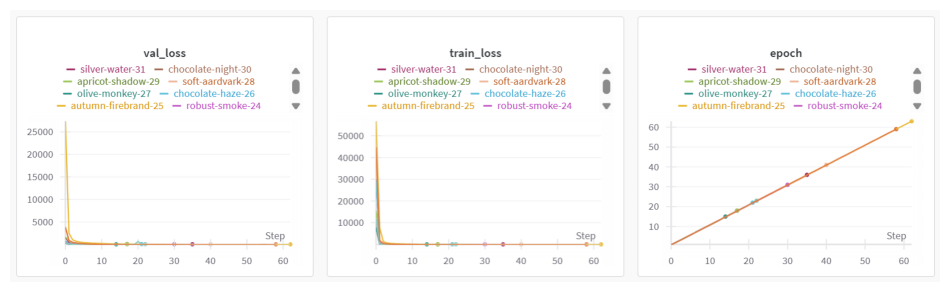

In [91]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "S1_NN_loss.png"
img = mpimg.imread(image_path)

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

Find the best model

In [88]:
import wandb
import os

api = wandb.Api()

project_path = "yixuan228-imperial-college-london/DE_Groupwork G4"
runs = api.runs(project_path)  # Get all the runs

# save_dir = "wandb_artifacts"
# os.makedirs(save_dir, exist_ok=True)

Save all the model config

In [89]:
ls_summary, ls_config = [], []

best_run = None
best_val_loss = float('inf')

ls_config = [run.config for run in runs]
ls_summary = [run.summary._json_dict for run in runs]


Select the best model

In [90]:
best_run = None
best_loss = float("inf")  

for run in runs:
    # print(run.summary.keys())
    if "val_loss" in run.summary:  
        loss = run.summary["val_loss"]
        if loss < best_loss:  # best model with least loss
            best_loss = loss
            best_run = run

# Best model hyparparameters
if best_run:
    print("\nBest Model Found:")
    print(f"Run ID: {best_run.id}, Name: {best_run.name}, State: {best_run.state}")
    print(f"Lowest Validation Loss: {best_loss}")

    print("\nBest Model Hyperparameters (config):")
    for key, value in best_run.config.items():
        print(f"   {key}: {value}")

    print("\nBest Model Final Metrics (summary):")
    for key, value in best_run.summary.items():
        print(f"   {key}: {value}")
else:
    print("No valid runs found with 'loss' metric.")



Best Model Found:
Run ID: nbfzlfhc, Name: fearless-morning-12, State: finished
Lowest Validation Loss: 8.600484386515094

Best Model Hyperparameters (config):
   patience: 5
   max_epochs: 200
   hidden_units: 64
   hidden_layers: 2
   learning_rate: 0.001

Best Model Final Metrics (summary):
   _runtime: 19.7579481
   _step: 118
   _timestamp: 1742462047.419305
   _wandb: {'runtime': 19}
   epoch: 119
   train_loss: 8.823451982218003
   val_loss: 8.600484386515094


#### 3.1.4 Best NN Model Parameters

Using Nueral Network Models is a good way to predict the CO2 emssions based on the features given. After using W&B to grid search the hyperparameters grid, the best model is chosen based on the metric of validation loss.

The best model parameters are listed below:

**Hyperparameter**:\
    patience: 5\
    max_epochs: 200\
    hidden_units: 64\
    hidden_layers: 2\
    learning_rate: 0.001

**Running Performance:**\
    epoch: 119\
    Training loss: 8.823451982218003\
    Validation loss: 8.600484386515094




#### 3.1.5 K-fold on Best NN Model 

Initialize NN model configuration, set hyperparameter grid.

In [103]:
# Hyperparameter grid
hidden_size = 64    # Numbers of neurons in each hidden layer
num_layer = 2       # Numbers of hidden layers
learning_rate = 0.001     # Learning rates

num_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
batch_size = 64
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

Output k-fold validation results

In [104]:
from torch.utils.data import Subset
from torch import optim

# Save MSE and True/Predict Values---------------------------
nn_k_fold_mse = []
nn_k_fold_R2 = []
nn_k_fold_mae = []
nn_k_fold_mape = []   

# Train and Evaluate the model----------------------------
print(f'Best Neural Network Model:\n')
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_df)):

    # get the training and validation data
    train_subset  = Subset(train_dataset, train_index)
    val_subset = Subset(train_dataset, val_index)

    # Data loader
    train_loader = DataLoader(dataset=train_subset , batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

    # Initialize and train the model
    nn_model = MultiLayerPerceptron(input_size, hidden_size, num_layer, output_size).to(device)

    criterion = nn.MSELoss()  # MSE as loss function
    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)  # Adam as optimizer

    for epoch in range(num_epochs):
        nn_model.train()
        total_loss = 0
        i = 0

        for X_batch, y_batch in train_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # if (epoch+1) % 10 == 0:
        #     print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # Validate the model
    nn_model.eval()

    y_true_fold = []
    y_pred_fold = []

    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

            # y_true_fold.append(y_batch.cpu.numpy())     
            # y_pred_fold.append(y_pred.cpu.numpy())      

            y_true_fold.append(y_batch.cpu().detach().numpy())  # true value
            y_pred_fold.append(y_pred.cpu().detach().numpy())   # predicted value

    y_true_fold = np.concatenate(y_true_fold, axis=0).flatten()
    y_pred_fold = np.concatenate(y_pred_fold, axis=0).flatten()

    mse = mean_squared_error(y_true_fold, y_pred_fold)
    r2 = r2_score(y_true_fold, y_pred_fold)
    mae = mean_absolute_error(y_true_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_true_fold, y_pred_fold)

    nn_k_fold_mse.append(mse)
    nn_k_fold_R2.append(r2)
    nn_k_fold_mae.append(mae)
    nn_k_fold_mape.append(mape)
    
    print(f"Fold {fold+1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(nn_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")


Best Neural Network Model:

Fold 1 Validation Dataset MSE: 5.7054
Fold 2 Validation Dataset MSE: 7.5513
Fold 3 Validation Dataset MSE: 8.5964
Fold 4 Validation Dataset MSE: 6.8910
Fold 5 Validation Dataset MSE: 7.8641
Fold 6 Validation Dataset MSE: 8.3933
Fold 7 Validation Dataset MSE: 7.0964
Fold 8 Validation Dataset MSE: 11.1679
Fold 9 Validation Dataset MSE: 7.0397
Fold 10 Validation Dataset MSE: 18.7081
Fold 11 Validation Dataset MSE: 9.9586
Fold 12 Validation Dataset MSE: 6.5334
Fold 13 Validation Dataset MSE: 7.6948
Fold 14 Validation Dataset MSE: 7.2341
Fold 15 Validation Dataset MSE: 7.7137
Fold 16 Validation Dataset MSE: 6.2179
Fold 17 Validation Dataset MSE: 7.7282
Fold 18 Validation Dataset MSE: 6.5246
Fold 19 Validation Dataset MSE: 8.7707
Fold 20 Validation Dataset MSE: 7.1306

K-Fold Average MSE: 8.2260

--------Finished training and validating the model!--------


Neural Network Model:
    Test Dataset MSE: 7.8916
    Test Dataset R2: 0.9977
    Test Dataset MAE: 2.0766
    Test Dataset MAPE: 0.0083


Text(0.5, 1.0, 'Neural Network Model: Observed vs Predicted values')

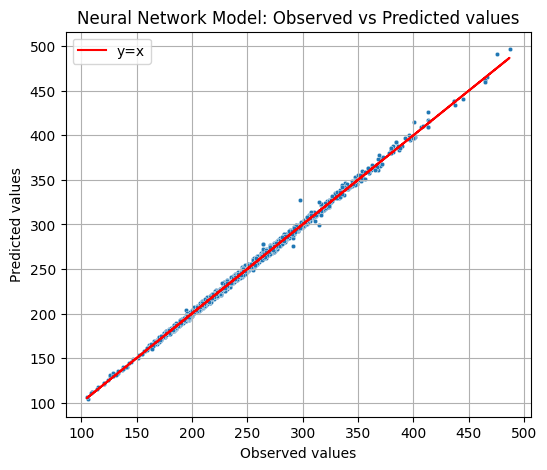

In [106]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE
nn_model.eval()

# Get the prediction and true values
nn_test_true = []
nn_test_pred = []

val_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_Loader:

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = nn_model(X_batch)
        loss = criterion(y_pred, y_batch)
        val_loss += loss.item()

        nn_test_true.append(y_batch.cpu().detach().numpy())     # true value
        nn_test_pred.append(y_pred.cpu().detach().numpy())      # predicted value

# concatenate the true and predicted values
nn_test_true = np.concatenate(nn_test_true, axis=0).flatten()
nn_test_pred = np.concatenate(nn_test_pred, axis=0).flatten()

nn_test_r2 = r2_score(nn_test_pred, nn_test_true)
nn_test_mse = mean_squared_error(nn_test_pred, nn_test_true)
nn_test_mae = mean_absolute_error(nn_test_pred, nn_test_true)
nn_test_mape = mean_absolute_percentage_error(nn_test_pred, nn_test_true)

# Output
print(f'Neural Network Model:')
print(f"    Test Dataset MSE: {nn_test_mse:.4f}")
print(f"    Test Dataset R2: {nn_test_r2:.4f}")
print(f"    Test Dataset MAE: {nn_test_mae:.4f}")
print(f"    Test Dataset MAPE: {nn_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(nn_test_true, nn_test_pred, ax)
plt.title('Neural Network Model: Observed vs Predicted values')

In [107]:
print(f"Test Dataset MSE: {nn_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(nn_k_fold_mse):.4f}")

Test Dataset MSE: 7.8916
Validation Dataset MSE: 8.2260


### 3.1.6 Save the NN Model Performance

Output of Best NN Model

- Output will include two types of data: Validation values, and Test Values, and combine those into one dataframe.

- Validation RSE:  1 x 20    Test RSE: 1 x 1

- Validation R2:   1 x 20    Test R2:  1 x 1

- Validation MAE:  1 x 20    Test MAE:  1 x 1

- Validation MAPE: 1 x 20    Test MAPE:  1 x 1

- So the output dataframe should include:

    - **4 rows**: RSE, R2, MAE and MAPE 
    
    - **21 cols**:  first 20 as validation metrics, with the last one being test metric

In [108]:
# Save the output of Best NN Model 
nn_metrics = pd.DataFrame([nn_k_fold_mse, nn_k_fold_R2, nn_k_fold_mae, nn_k_fold_mape])

# Add Test results
nn_metrics["Test_results"] = [nn_test_mse, nn_test_r2, nn_test_mae, nn_test_mape]


In [117]:
nn_metrics.columns = [f"fold_{i+1}" for i in range(20)] + ["Test"]
nn_metrics.index = ['MSE', 'R2', 'MAE', 'MAPE']


In [118]:
nn_metrics

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,...,fold_12,fold_13,fold_14,fold_15,fold_16,fold_17,fold_18,fold_19,fold_20,Test
MSE,5.705410,7.551312,8.596402,6.891008,7.864084,8.393311,7.096413,11.167949,7.039723,18.708132,...,6.533398,7.694758,7.234126,7.713703,6.217944,7.728242,6.524597,8.770668,7.130594,7.891622
R2,0.998276,0.997998,0.997880,0.998047,0.997520,0.997697,0.997966,0.996300,0.997954,0.994699,...,0.998116,0.997630,0.997359,0.997739,0.998165,0.997640,0.998117,0.997101,0.998019,0.997746
MAE,1.917849,2.163414,2.138202,2.027597,2.208934,2.180449,1.929476,2.380876,2.201027,2.377823,...,2.076570,2.101847,2.036131,2.062179,2.054636,2.157667,2.013144,2.306645,2.039979,2.076640
MAPE,0.007895,0.008399,0.008332,0.008125,0.008775,0.008782,0.007917,0.009497,0.008653,0.010289,...,0.008518,0.008508,0.008199,0.008148,0.008239,0.008693,0.008017,0.009209,0.007996,0.008300


In [119]:
nn_metrics.to_csv("Best_NN_Model_performance.csv", index=True)